# Evaluation of Models on Top-N Recommendation Task

## Set Up
Import modules and define model classes.

In [1]:
# Import modules
import pickle
import unittest
import numpy as np
import pandas as pd
from unittest import TestCase
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, tmean
from pandas.api.types import CategoricalDtype
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.model_selection import train_test_split

# Define globals & settings
FONT_SIZE = 18
DIMENSIONS = (10, 6)
plt.rcParams.update({'font.size': FONT_SIZE})

In [2]:
class SVDModel:
    def __init__(self, n_components):
        self.k = n_components
        self.SVD = TruncatedSVD(n_components=self.k)
    
    def fit(self, X):
        self.SVD.fit(X)
    
    def predict(self, user_ratings):
        reduced_user_ratings = self.SVD.transform(user_ratings)
        recast = self.SVD.inverse_transform(reduced_user_ratings)
        return csr_matrix(recast)

class AverageRatingModel:
    def __init__(self, incl_zeros=False):
        self.incl_zeros = incl_zeros
    
    def _tile(self, vec, n, dtype):
        return csr_matrix(np.ones([n,1],dtype=dtype) *\
            csr_matrix(self.avg, dtype=dtype))
    
    def fit(self, training_ratings):
        self.X = training_ratings
        
        self.avg = self.X.sum(axis=0)
        if self.incl_zeros:
            self.avg = self.avg / self.X.shape[0]
        else:
            col_optimized = csc_matrix(self.X)
            denom = (col_optimized > 0).sum(axis=0)
            denom[denom == 0] = 1
            self.avg = self.avg / denom
        self.avg = np.asarray(self.avg)
    
    def predict(self, user_ratings, dtype=np.float32, condense=False):   
        if condense:
            return csr_matrix(self.avg, dtype=dtype)
        else:
            return self._tile(self.avg, user_ratings.shape[0], dtype)

In [3]:
svd_model = None
with open("svd_model.pickle", "rb") as datafile:
    svd_model = pickle.load(datafile)

In [4]:
avg_rating_model = None
with open("avg_rating_model.pickle", "rb") as datafile:
    avg_rating_model = pickle.load(datafile)

In [5]:
probe = None
with open("X_test.pickle", "rb") as datafile:
    probe = pickle.load(datafile)

## Evaluation
We use our own implementation of the recall metric for the top-N recommendation task described in the paper [Performance of Recommender Algorithms
on Top-N Recommendation Tasks](https://dl.acm.org/doi/pdf/10.1145/1864708.1864721) by Cremonesi et al. We do not reproduce the testing steps or derivation of the recall formula here. Please refer to either the paper, or our previous notebook on kNN.

In [8]:
#X_test = probe[:,np.asarray(np.any((probe == 5).todense(), axis=0)).ravel()]
X_test = probe

only_relevant_mask = np.asarray(np.any((probe == 5).todense(), axis=0)).ravel()
actual_X_test = probe[:,only_relevant_mask]

In [10]:
# Globals
pr_results = {
    "Model Type": [],
    "Recall": [],
    "N": []
}

prediction_set_size = 1000

# Sweep values
users = range(probe.shape[0])

Ns = [1, 5, 10, 100, 1000, 1001]

# Utility lambdas
compl_mask_to_indices = lambda row: np.where(~row.todense())[1]
mask_to_indices = lambda row: np.where(row.todense())[1]
squish = lambda arr: np.asarray(arr.todense()).ravel()

for model, model_name in [(svd_model, "SVD"), (avg_rating_model, "Average Ratings")]:
    for user in tqdm(users):
        # sample unrated down to prediction set size
        unrated_indices = np.random.choice(compl_mask_to_indices(actual_X_test[user] != 0),
                                           size=prediction_set_size)
        rated_indices = mask_to_indices(actual_X_test[user] == 5)

        pred = model.predict(X_test[user])
        # Discard all predictions for items that are not 5 stars
        pred = pred[:,only_relevant_mask]

        unrated_pred = pred[:,unrated_indices]
        rated_pred = pred[:,rated_indices]

        for N in Ns:
            pos = np.searchsorted(squish(unrated_pred),
                                  squish(rated_pred))
            hits = np.sum(pos <= N-1) # subtract 1 to adjust for zero indexing
            recall = hits/actual_X_test.shape[0]

            pr_results["Recall"].append(recall)
            pr_results["N"].append(N)
            pr_results["Model Type"].append(model_name)

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/2800 [00:00<?, ?it/s]

In [11]:
results_df_pr = pd.DataFrame(pr_results)

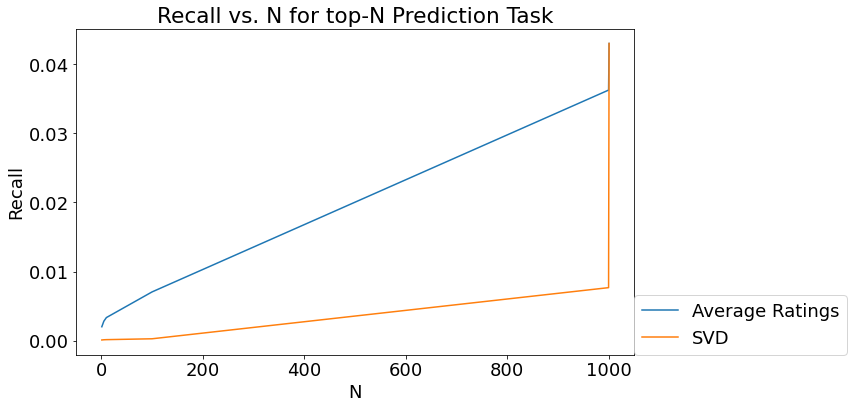

In [12]:
y_axis = "Recall"
results_df_pr.groupby(["N", "Model Type"], as_index=False)\
    .mean()\
    .set_index("N")\
    .groupby(["Model Type"])\
    [y_axis]\
    .plot(x="N",
          y=y_axis,
          title=f"{y_axis} vs. N for top-N Prediction Task",
          xlabel="N",
          ylabel=y_axis,
          legend=True)

plt.legend(loc=(1,0))
plt.gcf().set_size_inches(DIMENSIONS)